In [1]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, binned_statistic_dd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file = "../data/SSCURVES.xlsx"

In [3]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [4]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

In [5]:
def tsos(y):
    """Total sum of squares"""
    return np.sum((y-np.mean(y))**2)

def rsos(y, y_pred):
    """Residual sum of squares"""
    residuals = y - y_pred
    return np.sum(residuals**2)


def r_squared(y, y_pred):
    ss_tot = tsos(y)
    ss_res = rsos(y, y_pred)
    return 1 - ss_tot / ss_res

In [6]:
rs_results = []
def save_individual_fit(x, y, popt, sample_id, r2, i):
    y_pred = logistic(x, *popt)
    rs_results.append(r2)
    plt.figure(figsize=(3, 3), tight_layout=True)
    plt.plot(np.linspace(0, 2.5, 1000), logistic(np.linspace(0, 2.5, 1000), *popt), color='red', label="logistic fit")
    plt.scatter(x, y, marker='x', color='black', label="data")
    plt.xlabel("Stretch")
    plt.ylabel("Stress [MPa]")
    plt.title(f"Sample {sample_id}")
    plt.xlim([1, 1.6])
    plt.ylim([0, 10])
    plt.annotate(f"$R^2 = {r2:.4f}$", [0.1, 0.85], xycoords='axes fraction')
    if sample_id == 6:
        plt.legend(loc='center left')
    plt.savefig(f"outputs/compare_output/sample_{sample_id}_{i}.pdf")

In [7]:
# TRAINING SET
sample_ids = np.array([44, 10, 12, 46, 37, 44, 15, 28, 19,  6,  6, 35, 32, 30, 16, 18])
outputs = np.array([
    [ 7.3008, 19.2656,  1.2900],
    [ 3.3984, 29.0156,  1.2256],
    [ 3.8145, 21.5000,  1.2598],
    [ 8.2891, 16.2812,  1.2637],
    [ 0.5483, 27.1250,  1.0957],
    [ 7.1836, 19.2812,  1.2783],
    [14.2812, 26.9062,  1.2119],
    [ 1.1279, 29.9375,  1.1768],
    [ 3.1895, 21.3438,  1.2891],
    [11.9141, 23.6406,  1.3340],
    [11.9297, 23.3438,  1.3623],
    [ 0.4766, 27.5781,  1.1797],
    [ 0.3120, 32.9062,  1.1973],
    [ 2.0391, 26.9062,  1.1572],
    [ 3.9785, 29.3281,  1.2910],
    [ 2.9805, 23.3281,  1.2109]
])

In [8]:
# # TEST SET
# sample_ids = np.array([np.repeat(x, 20) for x in range(51, 62)]).flatten()
# outputs = np.array([[ 5.7695, 19.7344,  1.2881],
#         [ 6.0312, 19.8281,  1.2881],
#         [ 6.0039, 19.8281,  1.2852],
#         [ 5.7109, 19.8750,  1.2900],
#         [ 5.9375, 19.7344,  1.2939],
#         [ 5.8516, 19.9688,  1.2891],
#         [ 6.0664, 19.7812,  1.2891],
#         [ 5.7305, 19.9844,  1.2969],
#         [ 5.7773, 19.8594,  1.2949],
#         [ 5.5859, 20.2500,  1.2939],
#         [ 5.7695, 19.6406,  1.2852],
#         [ 5.5625, 20.2812,  1.2988],
#         [ 5.9727, 19.7812,  1.2881],
#         [ 5.6602, 20.0000,  1.2832],
#         [ 5.9688, 19.9375,  1.2939],
#         [ 5.9180, 19.6250,  1.2920],
#         [ 6.2656, 20.0625,  1.3018],
#         [ 6.6523, 19.9531,  1.3018],
#         [ 5.6250, 20.0469,  1.2852],
#         [ 7.2148, 18.8906,  1.2969],
#         [ 2.5605, 21.7188,  1.1719],
#         [ 2.5801, 21.7031,  1.1719],
#         [ 2.4688, 21.8906,  1.1680],
#         [ 2.7188, 21.7188,  1.1670],
#         [ 3.0684, 21.1406,  1.1680],
#         [ 3.0898, 21.0781,  1.1719],
#         [ 2.9355, 21.1406,  1.1729],
#         [ 2.5625, 21.5312,  1.1807],
#         [ 3.3262, 20.7656,  1.1758],
#         [ 2.1074, 21.9688,  1.2012],
#         [ 2.1758, 21.8438,  1.2148],
#         [ 2.9883, 20.9531,  1.1680],
#         [ 2.2793, 21.7656,  1.2158],
#         [ 2.2676, 21.8125,  1.2305],
#         [ 3.0430, 20.9062,  1.1670],
#         [ 2.2285, 21.7656,  1.2373],
#         [ 2.5723, 22.3281,  1.2383],
#         [ 3.2305, 21.0000,  1.1650],
#         [ 2.6035, 22.3750,  1.2402],
#         [ 2.4941, 23.2656,  1.2402],
#         [ 2.2266, 21.6406,  1.1631],
#         [ 2.6973, 20.6094,  1.1494],
#         [ 2.6191, 20.5000,  1.1436],
#         [ 2.6016, 21.6562,  1.1904],
#         [ 2.8711, 20.3281,  1.1494],
#         [ 2.9023, 22.5156,  1.1992],
#         [ 2.6309, 20.6406,  1.1592],
#         [ 2.5664, 20.6875,  1.1514],
#         [ 2.6816, 22.3906,  1.2158],
#         [ 2.7422, 20.9062,  1.1562],
#         [ 2.9785, 20.8750,  1.1582],
#         [ 3.3359, 20.4531,  1.1689],
#         [ 2.9004, 23.0000,  1.2393],
#         [ 2.7871, 21.1719,  1.1699],
#         [ 2.4668, 21.7031,  1.1699],
#         [ 2.6855, 21.4375,  1.1670],
#         [ 2.6367, 22.5312,  1.2637],
#         [ 2.7676, 21.5938,  1.1797],
#         [ 2.5137, 22.0000,  1.1924],
#         [ 2.2891, 21.7344,  1.2188],
#         [ 4.2656, 21.8594,  1.2139],
#         [ 4.1250, 21.5625,  1.2178],
#         [ 4.1289, 21.0312,  1.2139],
#         [ 3.9434, 21.9688,  1.2139],
#         [ 4.5156, 22.2969,  1.2217],
#         [ 5.0938, 24.2812,  1.2021],
#         [ 4.2812, 22.0156,  1.2188],
#         [ 4.1445, 21.0156,  1.2158],
#         [ 5.5586, 30.2344,  1.2178],
#         [ 3.6387, 21.1562,  1.2158],
#         [ 3.8809, 21.6719,  1.2002],
#         [ 3.8301, 21.3906,  1.2021],
#         [ 5.1055, 34.3125,  1.2598],
#         [ 3.6113, 21.3125,  1.1904],
#         [ 3.9570, 21.2500,  1.1943],
#         [ 3.3457, 21.7812,  1.1865],
#         [ 5.1445, 30.8750,  1.2354],
#         [ 2.9160, 21.5938,  1.1719],
#         [ 3.1035, 21.6719,  1.1777],
#         [ 3.4902, 21.3125,  1.1797],
#         [ 5.0547, 22.3125,  1.2471],
#         [ 5.3711, 22.5469,  1.2510],
#         [ 1.7754, 21.3906,  1.2324],
#         [ 1.8691, 21.7812,  1.2090],
#         [ 1.7949, 21.4219,  1.2441],
#         [ 3.3008, 22.4844,  1.2480],
#         [ 1.7109, 21.6719,  1.2246],
#         [ 1.9248, 21.7500,  1.2275],
#         [ 1.6914, 22.1562,  1.2314],
#         [ 2.1895, 21.7812,  1.2051],
#         [ 3.0098, 22.2969,  1.2480],
#         [ 2.0684, 21.7969,  1.2422],
#         [ 1.6865, 21.8906,  1.2295],
#         [ 2.3555, 22.1562,  1.2549],
#         [ 1.7412, 21.7812,  1.2441],
#         [ 1.8555, 21.5156,  1.2344],
#         [ 2.3379, 21.9062,  1.2256],
#         [ 2.4727, 21.7656,  1.2412],
#         [ 2.8926, 21.4844,  1.2207],
#         [ 2.9473, 21.3750,  1.2158],
#         [ 3.5469, 20.5312,  1.1826],
#         [ 3.9883, 20.4219,  1.2070],
#         [ 4.0391, 21.1250,  1.2002],
#         [ 4.8008, 20.5312,  1.2158],
#         [ 3.7559, 20.0312,  1.1973],
#         [ 4.3203, 20.6562,  1.2197],
#         [ 3.4238, 20.4375,  1.2021],
#         [ 3.9785, 18.9688,  1.2139],
#         [ 6.2188, 19.8594,  1.2295],
#         [ 3.6211, 20.3906,  1.2021],
#         [ 3.9961, 20.5000,  1.2041],
#         [ 7.4062, 18.3906,  1.2334],
#         [ 4.0625, 21.0000,  1.1982],
#         [ 5.1641, 20.5469,  1.2109],
#         [ 6.7578, 19.5156,  1.2246],
#         [ 5.4414, 22.4531,  1.1885],
#         [ 6.4688, 23.6406,  1.1836],
#         [ 6.4219, 20.1250,  1.2334],
#         [ 6.2852, 22.4844,  1.1895],
#         [ 6.2148, 19.8125,  1.2422],
#         [ 6.0195, 18.6094,  1.2188],
#         [ 6.2148, 18.2031,  1.2119],
#         [ 5.9805, 18.6406,  1.2129],
#         [ 5.4648, 19.0938,  1.2021],
#         [ 5.8555, 18.4219,  1.2041],
#         [ 5.2500, 19.1562,  1.2041],
#         [ 6.3867, 18.0781,  1.2256],
#         [ 4.8398, 19.8281,  1.2119],
#         [ 5.9922, 18.5000,  1.2285],
#         [ 6.2539, 18.6562,  1.2412],
#         [ 5.0312, 19.7031,  1.2119],
#         [ 5.9180, 19.0625,  1.2197],
#         [ 6.2031, 18.9062,  1.2295],
#         [ 7.1953, 18.1875,  1.2783],
#         [ 5.3242, 19.7969,  1.2441],
#         [ 6.0195, 19.6250,  1.2754],
#         [ 5.9297, 19.8750,  1.2871],
#         [ 5.0664, 19.9062,  1.2295],
#         [ 6.2227, 19.5938,  1.2930],
#         [ 5.5586, 20.7188,  1.3145],
#         [ 4.5781, 19.2812,  1.2217],
#         [ 5.7227, 18.4375,  1.2305],
#         [ 5.2578, 19.3281,  1.2256],
#         [ 4.6719, 19.0938,  1.2236],
#         [ 5.4258, 19.6250,  1.2305],
#         [ 5.7188, 18.5469,  1.2178],
#         [ 5.4414, 19.6094,  1.2344],
#         [ 6.2656, 18.0781,  1.2246],
#         [ 6.9766, 17.4219,  1.2295],
#         [ 5.8125, 19.3281,  1.2480],
#         [ 6.7656, 17.9375,  1.2432],
#         [ 5.4180, 19.7500,  1.2578],
#         [ 6.2031, 19.4844,  1.2793],
#         [ 6.8750, 18.0781,  1.2559],
#         [ 5.4297, 20.3281,  1.2578],
#         [ 5.3633, 21.2656,  1.2725],
#         [ 6.6797, 18.3281,  1.2607],
#         [ 5.1914, 21.2031,  1.2695],
#         [ 6.1211, 19.0156,  1.2490],
#         [ 5.3672, 20.4375,  1.2578],
#         [10.8359, 20.9688,  1.2373],
#         [ 9.5625, 19.6250,  1.2500],
#         [10.6250, 20.7969,  1.2422],
#         [ 9.1953, 19.1875,  1.2471],
#         [10.7578, 21.1406,  1.2354],
#         [ 9.3750, 20.9062,  1.2432],
#         [10.4531, 21.7969,  1.2471],
#         [10.9297, 22.8750,  1.2686],
#         [ 9.6250, 22.9062,  1.2959],
#         [10.0312, 19.6875,  1.2432],
#         [ 9.8516, 24.7031,  1.2637],
#         [11.5938, 24.8125,  1.2715],
#         [ 9.0156, 18.5312,  1.2666],
#         [10.9688, 25.0469,  1.2852],
#         [ 8.6797, 18.3438,  1.2783],
#         [ 9.0234, 22.4844,  1.3018],
#         [ 8.6641, 19.9844,  1.3359],
#         [ 6.7812, 18.1094,  1.2686],
#         [ 7.1016, 25.7031,  1.3037],
#         [ 6.7852, 17.7969,  1.2617],
#         [ 6.2227, 20.6406,  1.2568],
#         [ 4.7578, 21.1094,  1.2588],
#         [ 6.5625, 20.0625,  1.2549],
#         [ 5.2656, 20.7500,  1.2549],
#         [ 4.6953, 20.6875,  1.2539],
#         [ 5.2188, 21.5156,  1.2666],
#         [ 5.7344, 20.4219,  1.2451],
#         [ 5.0234, 21.4062,  1.2676],
#         [ 5.2969, 21.3594,  1.2695],
#         [ 5.4258, 20.2188,  1.2432],
#         [ 4.8711, 20.7500,  1.2676],
#         [ 4.9375, 20.2500,  1.2627],
#         [ 6.2812, 20.4375,  1.2334],
#         [ 5.4062, 19.2969,  1.2490],
#         [ 6.5156, 18.6719,  1.2627],
#         [ 6.6602, 20.2344,  1.2354],
#         [ 7.0469, 17.8906,  1.2529],
#         [ 6.2344, 19.5469,  1.2490],
#         [ 7.0312, 21.7188,  1.2354],
#         [ 7.0234, 18.0938,  1.2539],
#         [ 3.2773, 20.7812,  1.2051],
#         [ 3.4082, 20.5938,  1.2002],
#         [ 3.4199, 20.8281,  1.2041],
#         [ 3.5059, 21.2969,  1.1943],
#         [ 3.3867, 20.7188,  1.2256],
#         [ 3.2773, 20.9062,  1.1777],
#         [ 3.0742, 22.9844,  1.2119],
#         [ 3.4512, 20.9688,  1.2109],
#         [ 3.6348, 23.8125,  1.2197],
#         [ 3.4609, 20.9062,  1.2080],
#         [ 3.4121, 23.9219,  1.2324],
#         [ 3.2480, 23.1562,  1.2139],
#         [ 3.4688, 21.1406,  1.2041],
#         [ 3.5039, 22.7500,  1.2002],
#         [ 2.5938, 22.4531,  1.2207],
#         [ 4.0625, 22.9844,  1.2344],
#         [ 2.7715, 23.2969,  1.2412],
#         [ 2.7207, 23.0938,  1.2305],
#         [ 2.2207, 21.9688,  1.2412],
#         [ 3.0371, 23.6406,  1.2012]]
# )

In [9]:
# # TEST SET 54
# sample_ids = np.repeat(54, 20)
# outputs = np.array([[ 4.4531, 29.7500,  1.3672],
#         [ 4.3594, 30.1250,  1.3750],
#         [ 4.7188, 27.9062,  1.3564],
#         [ 4.4609, 29.3281,  1.3643],
#         [ 4.3672, 26.6094,  1.2998],
#         [ 4.6602, 28.7656,  1.3701],
#         [ 3.9844, 26.1094,  1.2988],
#         [ 3.2559, 29.0312,  1.3203],
#         [ 4.3086, 28.2656,  1.3291],
#         [ 3.5469, 28.8281,  1.3623],
#         [ 3.7773, 28.6719,  1.3721],
#         [ 4.0234, 28.3125,  1.3848],
#         [ 3.7812, 28.0781,  1.2930],
#         [ 4.1758, 28.3750,  1.3828],
#         [ 3.8828, 28.2188,  1.3379],
#         [ 3.6426, 27.8438,  1.3281],
#         [ 3.8633, 24.8125,  1.2646],
#         [ 3.4668, 27.9688,  1.2949],
#         [ 3.3340, 28.5938,  1.2637],
#         [ 5.8906, 27.8750,  1.2295]])

  6%|████                                                            | 4/63 [00:00<00:05, 11.06it/s]

[[11.9141 23.6406  1.334 ]
 [11.9297 23.3438  1.3623]]


 14%|█████████▏                                                      | 9/63 [00:01<00:10,  5.38it/s]

[[ 3.3984 29.0156  1.2256]]


 16%|██████████                                                     | 10/63 [00:02<00:11,  4.52it/s]

[[ 3.8145 21.5     1.2598]]


 22%|██████████████                                                 | 14/63 [00:02<00:08,  5.83it/s]

[[14.2812 26.9062  1.2119]]


 24%|███████████████                                                | 15/63 [00:02<00:09,  4.89it/s]

[[ 3.9785 29.3281  1.291 ]]


 27%|█████████████████                                              | 17/63 [00:03<00:10,  4.20it/s]

[[ 2.9805 23.3281  1.2109]]


 29%|██████████████████                                             | 18/63 [00:03<00:12,  3.73it/s]

[[ 3.1895 21.3438  1.2891]]


 43%|███████████████████████████                                    | 27/63 [00:04<00:04,  8.23it/s]

[[ 1.1279 29.9375  1.1768]]


 44%|████████████████████████████                                   | 28/63 [00:05<00:05,  6.17it/s]

[[ 2.0391 26.9062  1.1572]]


 48%|██████████████████████████████                                 | 30/63 [00:05<00:07,  4.57it/s]

[[ 0.312  32.9062  1.1973]]


 54%|██████████████████████████████████                             | 34/63 [00:06<00:05,  5.32it/s]

[[ 0.4766 27.5781  1.1797]]


 56%|███████████████████████████████████                            | 35/63 [00:06<00:06,  4.66it/s]

[[ 0.5483 27.125   1.0957]]


 67%|██████████████████████████████████████████                     | 42/63 [00:08<00:03,  5.81it/s]

[[ 7.3008 19.2656  1.29  ]
 [ 7.1836 19.2812  1.2783]]


 70%|████████████████████████████████████████████                   | 44/63 [00:08<00:04,  4.42it/s]

[[ 8.2891 16.2812  1.2637]]


100%|███████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.83it/s]

No person id information found for 62
No person id information found for 555


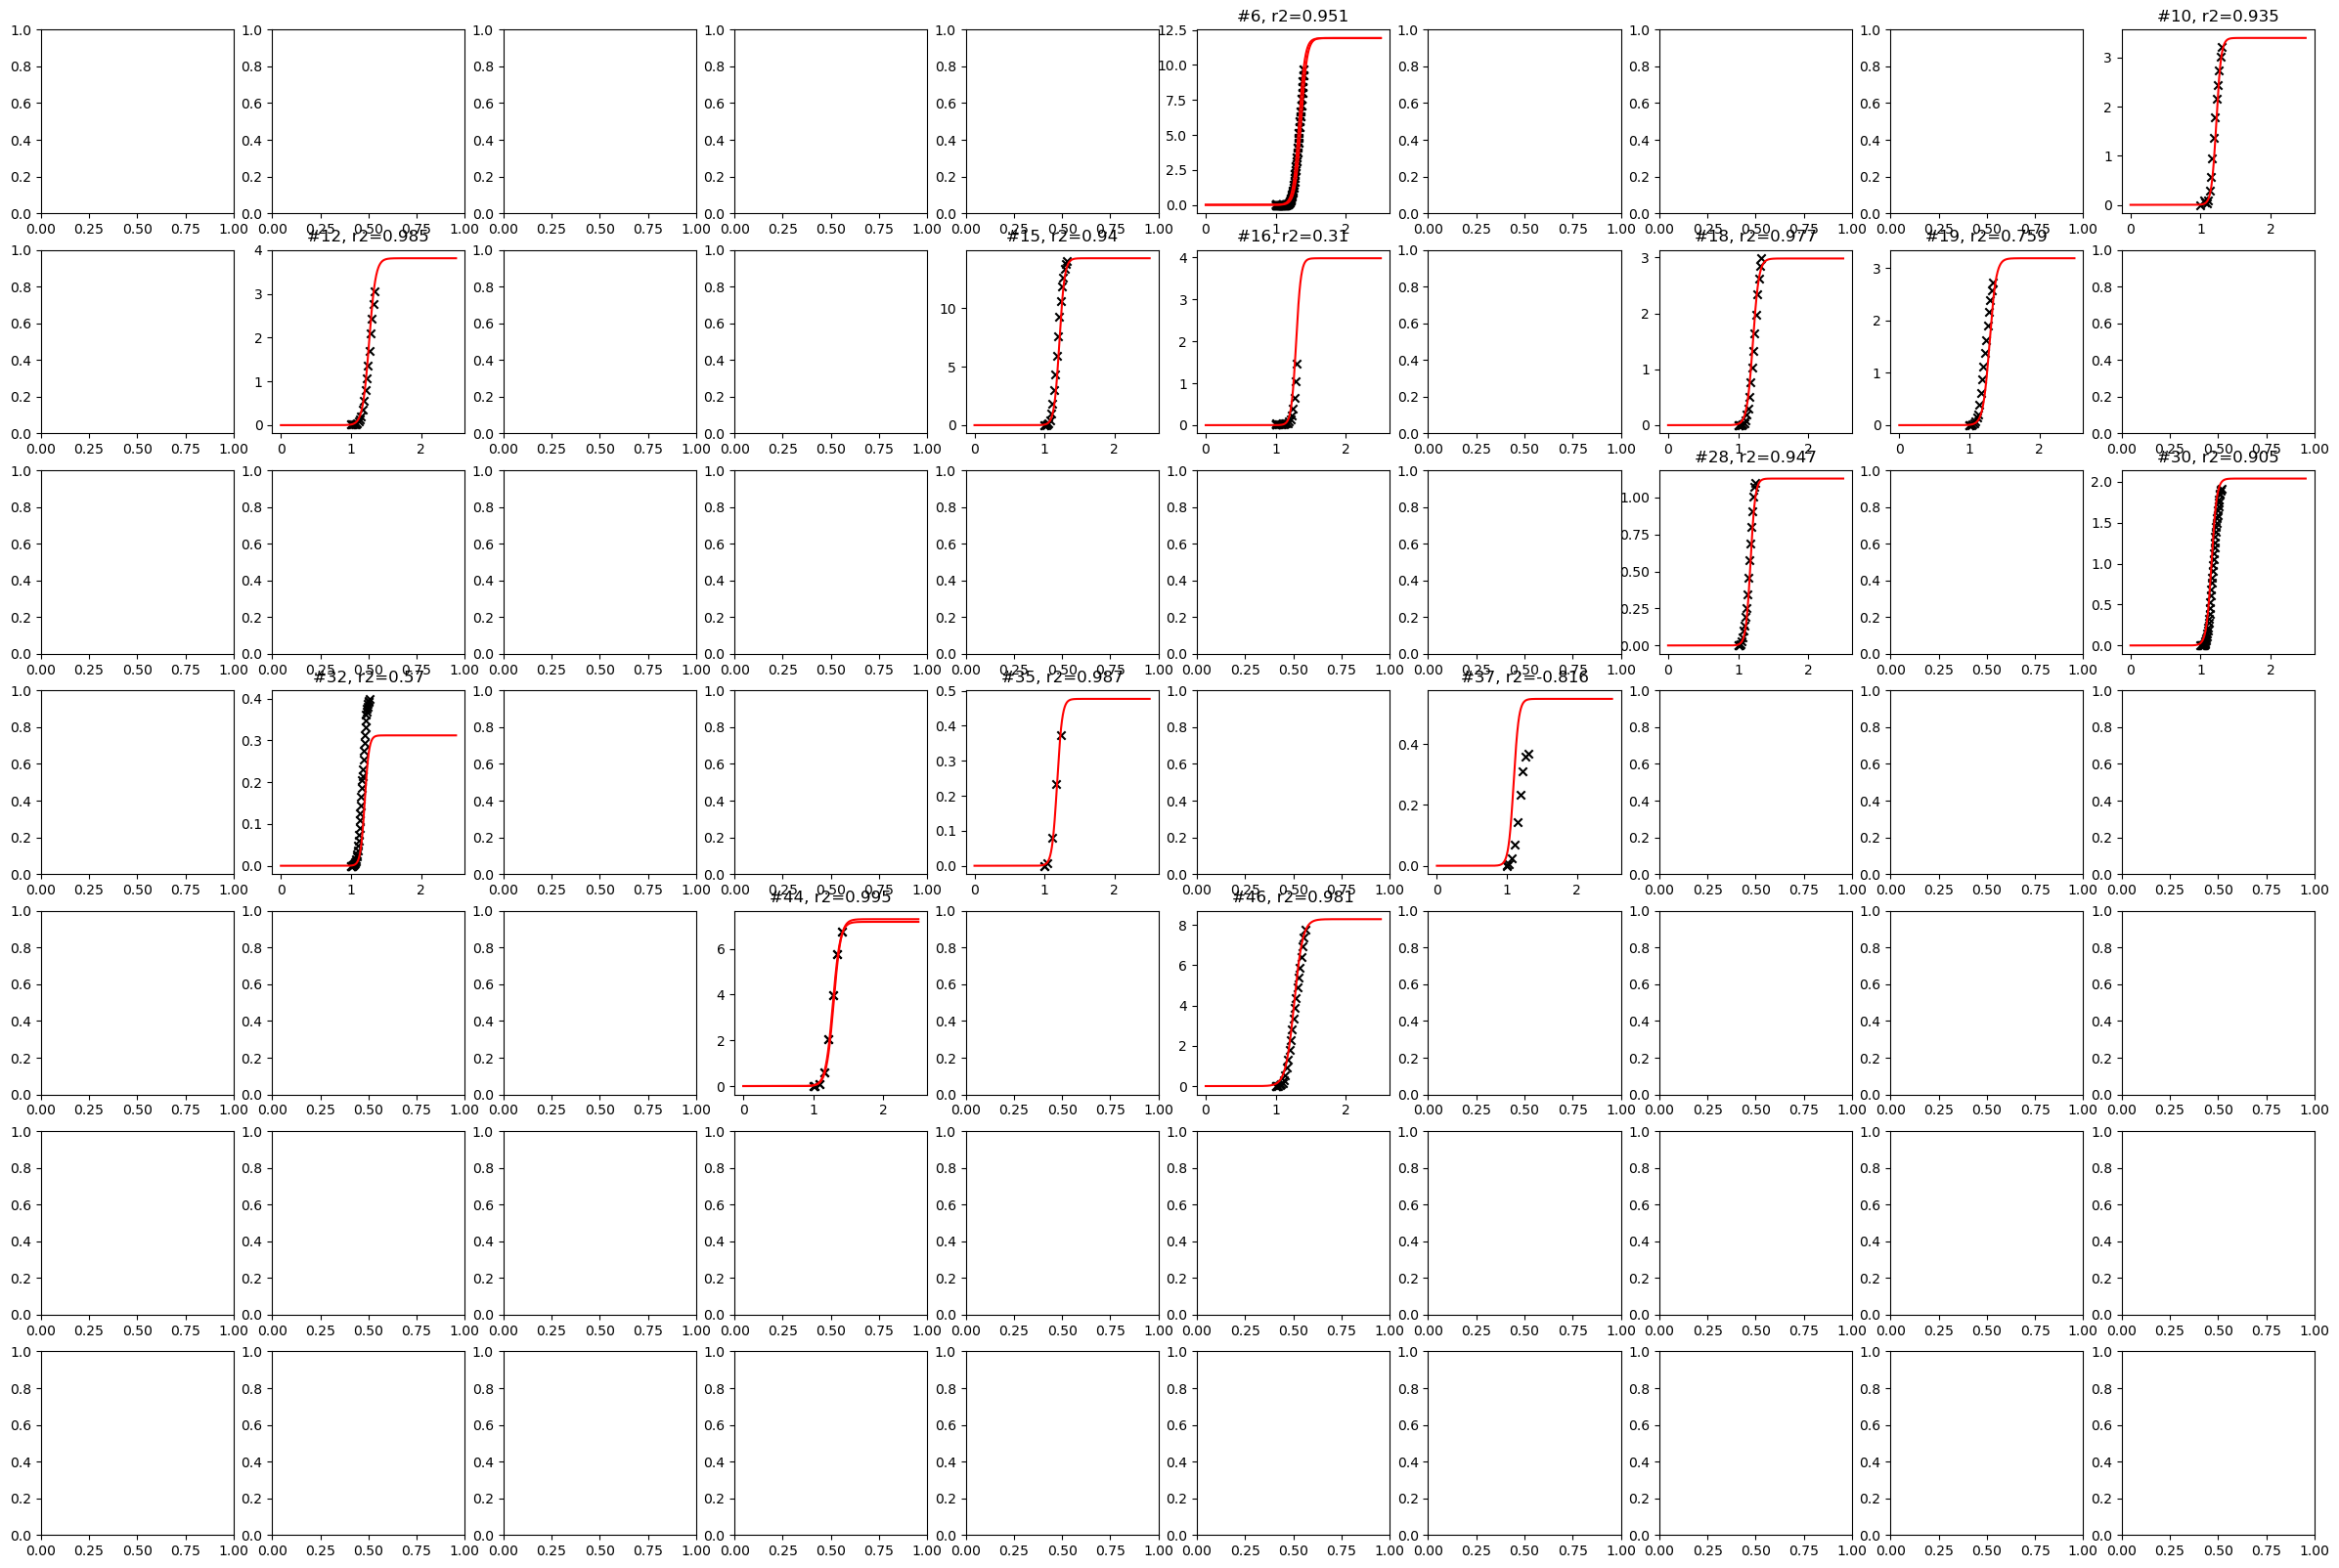

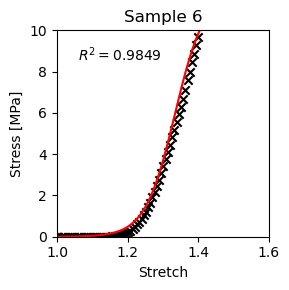

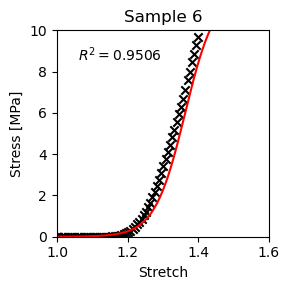

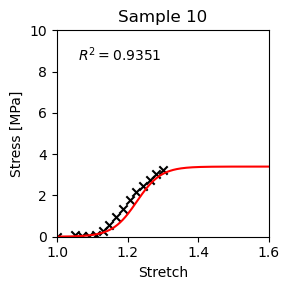

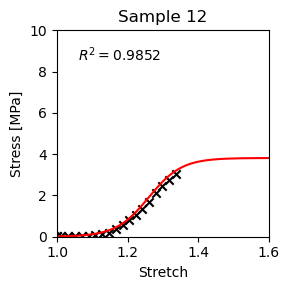

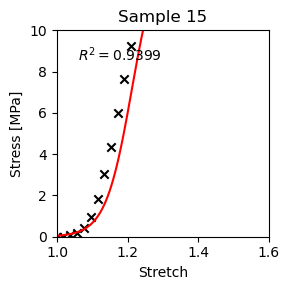

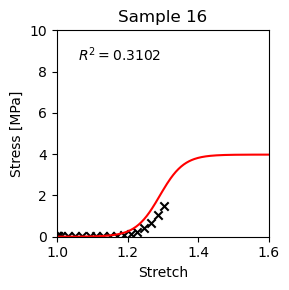

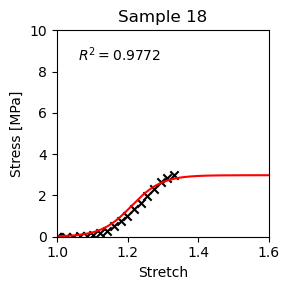

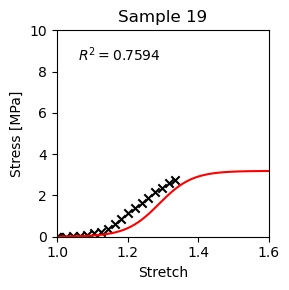

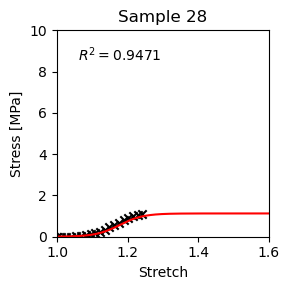

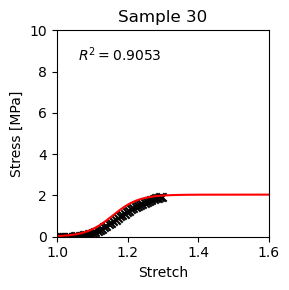

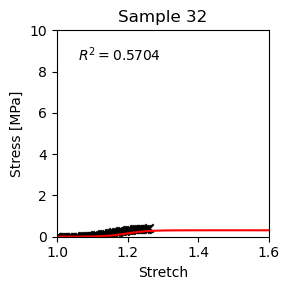

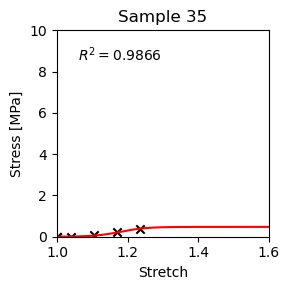

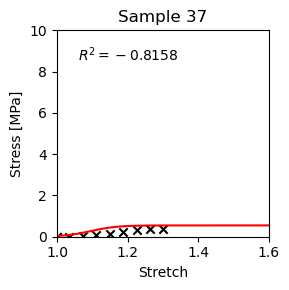

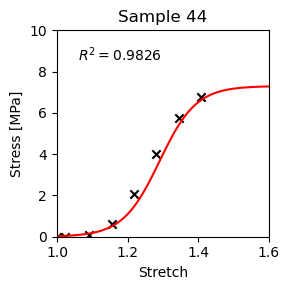

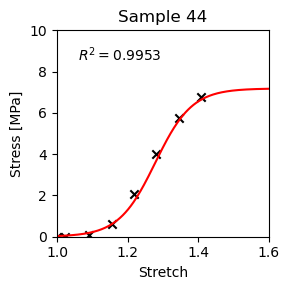

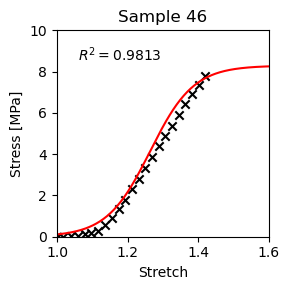

In [10]:
xls = pd.ExcelFile(file)

index_list =  []
person_ids = []
ages = []
sexes = []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)
results = {}

for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
        type = str(df['type'].iloc[0])
        sex = str(df['sex'].iloc[0])
        age = str(df['age'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        person_id = None
        continue

    if int(sheet) not in sample_ids:
        continue

    valid_type = 'thigh'
    if type != valid_type:
        tqdm.write(f"Only curves belonging to {valid_type} are included. Excluding person {person_id} (sheet {sheet})")
        continue

    
    results[int(sheet)] = outputs[np.argwhere(sample_ids == int(sheet))][:,0,:]
    print(results[int(sheet)])

    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    # Determined from ealier run.
    # lookup = {51: 0, 52: 2, 53: 1, 54:0, 55:1, 56:4, 57:3, 58:2, 59:1, 60:2, 61:0}
    # lookup = {}

    for i, result in enumerate(results[int(sheet)]):
        # try:
        #     if lookup[int(sheet)] != i:
        #         continue
        # except KeyError:
        #     print(int(sheet))
        r2 = r2_fn(y_data, logistic(x_data, *result))
        r2_list.append(r2)

        save_individual_fit(x_data, y_data, result, sheet, r2, i)

        ax.scatter(x_data, y_data, marker='x', color='black')
        ax.plot(x, logistic(x, *result), 'r-')
        ax.set_title(f"#{sheet}, r2={round(r2, 3)}")
        

plt.tight_layout()
plt.savefig("outputs/logistic_compare.png")
plt.show()
